In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn
import networkx as nx
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
import scipy.stats as stt
import scipy as sp
import re
import matplotlib
sys.path.append(r'\Users\takam\Documents\Code\line_loop\packages')
sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")

clrs = seaborn.color_palette()

seaborn.set(font_scale=1.5,style='ticks')


import mouse_poker as mpk
from mouse_poker.ephys_load import *
#import yutils

poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]
pos = np.array([1,-1])*poke_pos


In [2]:
sys.path.append(r'\\Users\\takam\\Documents\\Code\\line_loop\\packages')


In [3]:
def make_plot(res_dict,mx=1,color='mean'):
    plt.figure(figsize=(12,4))


#    mx = 1
    if color=='pval': cmap_ = 'RdYlGn_r'
    else: cmap_ = 'RdYlGn'
    cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

    plt.subplot(1,2,1)
    G0 = nx.DiGraph()
    G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos,color='.3')
    nx.draw(G0,pos=pos,alpha=.2,node_color='.3')


    G = nx.DiGraph()
    for k,v in res_dict.items():
        if color=='pval':
            c = stt.binom_test(np.sum(v),len(v),p=1/9.)
        else:
            c= np.mean(v)
        G.add_edge(int(k[0]),int(k[1]),color=cmap.to_rgba(c))

    colors = nx.get_edge_attributes(G,'color')

    nx.draw(G,
            pos=pos,edge_color=np.array(list(colors.values())),
            node_color='.3',
            node_size=768,
            connectionstyle="arc3,rad=-0.1",
            width=3
    )


    plt.subplot(1,2,2)

    plt.imshow(np.array([[0,mx]]).T,aspect=1001,cmap=cmap_)
    plt.gca().set_visible(False)
    cax = plt.axes([.6, 0.025, 0.025, 0.8])
    cbar = plt.colorbar(cax=cax)
    cbar.ax.set_ylabel("Proportion correct \n(probe trials)")
    plt.tight_layout()


#G = nx.Graph()


In [7]:

def get_inpoke_data(lines):
    
    event_line = [l for ix,l in enumerate(lines) if l[0]=='E'][0]
    state_line = [l for ix,l in enumerate(lines) if l[0]=='S'][0]

    event_dict = eval(event_line[2:-1])
    state_dict = eval(state_line[2:-1])
    event_dict2 = {v: k for k, v in event_dict.items()}

    inPoke_evs = sorted([(k,v) for k,v in event_dict.items() if (re.findall(r'poke_[0-9]',k) and 'out' not in k)])
    inPoke_ids = [i[1] for i in inPoke_evs]
    
    
    inPokes = []
    inPoke_ts = []
    for l_ in lines:
        d_ = re.findall('D [0-9]* ([0-9]*)\n',l_)

        if d_:
            if int(d_[0]) in inPoke_ids:

                t = re.findall('D ([0-9]*) [0-9]*\n',l_)[0]
                inPoke_ts.append(float(t))
                inPokes.append(int(event_dict2[int(d_[0])][-1]))
    return np.array(inPokes), np.array(inPoke_ts)


def get_target_at_t(T,next_pokes_targets,next_poke_target_ts):
    """ Function returns which poke is the target at a given point in time """
    if type(next_poke_target_ts)!=np.array:
        next_poke_target_ts = np.array(next_poke_target_ts)
        
    ix = np.min(np.where(next_poke_target_ts>T)[0])
    target = next_pokes_targets[ix]
    if ix==0:
        prev_target = 99
    else:
        prev_target = next_pokes_targets[ix-1]

    return target, prev_target

def get_tar_pokes(lines):
    """ Find out the times target pokes change"""
    next_pokes_targets = [int(l_[-2]) for l_ in lines if (l_[0]=='P' and 'nREWS' not in l_ and 'robe' not in l_)]
    next_poke_target_ts = [float(re.findall(r'P ([0-9]*)',l_)[0]) for l_ in lines if (l_[0]=='P' and 'nREWS' not in l_ and 'robe' not in l_)]
    return next_pokes_targets, next_poke_target_ts
    
    
def evaluate_probe_trials(lines,res_dict=None):
    
    has_probestart = any(['probe_start' in i for i in lines])
    #print(has_probestart)
    
    event_line = [l for ix,l in enumerate(lines) if l[0]=='E'][0]
    state_line = [l for ix,l in enumerate(lines) if l[0]=='S'][0]

    event_dict = eval(event_line[2:-1])
    state_dict = eval(state_line[2:-1])

    next_pokes_targets, next_poke_target_ts = get_tar_pokes(lines)
    try:
        session_variables = eval(re.findall(r'(\{.*\})',lines[-1])[0])
        probe_dur = float(session_variables['probe_dur'])
    except:
        print("WARNING NO PROBE DUR FOUND ASSUMING 2s")
        probe_dur = 2000
   
    if not has_probestart:
        probes = [float(re.findall('D ([0-9]*)',i)[0]) for i in lines if '33\n' in i and 'D' in i]
        probe_starts = np.array(probes)-probe_dur
    else:
        probe_starts = [float(re.findall(r'P ([0-9]*) probe_start',l_)[0]) for l_ in lines if 'probe_start' in l_]
        
    inPokes, inPoke_ts = get_inpoke_data(lines)
    if res_dict is None:
        res_dict = {}
    #print(len(probe_starts))
    #probe_starts = np.array(probes)-probe_dur
    for pt_ in probe_starts[:-1]:
        try:
            target,prev_target = get_target_at_t(pt_,next_pokes_targets,next_poke_target_ts)
            k_ = str(target) + str(prev_target)

            ix_ = np.min(np.where(np.array(inPoke_ts)>(pt_+10))[0])
            get_nextPoke = True
            while get_nextPoke:
                nextPoke = inPokes[ix_]-1
                nextPoke_t = inPoke_ts[ix_]
                if nextPoke!=prev_target:
                    get_nextPoke = False
                ix_ += 1


            correct = ((nextPoke==target) and ((nextPoke_t-pt_)<probe_dur))
            if k_ not in res_dict.keys():
                res_dict[k_] = [correct]
            else:
                res_dict[k_].append(correct)
        except:
            pass

    return res_dict

In [42]:
def get_rews(lines):
    
    event_line = [l for ix,l in enumerate(lines) if l[0]=='E'][0]
    state_line = [l for ix,l in enumerate(lines) if l[0]=='S'][0]

    event_dict = eval(event_line[2:-1])
    state_dict = eval(state_line[2:-1])
    event_dict2 = {v: k for k, v in event_dict.items()}
    rew_state = state_dict['deliver_reward']
    rew_ts = []
    for l_ in lines:
        if (l_[0]=='D' and (l_[-3])==str(rew_state)):
            rew_ts.append(float(re.findall('D ([0-9]*)',l_)[0]))
            #rew_locs.append()
    return rew_ts

In [43]:
fs_dir = r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_1/16164320657908795_task/"

In [44]:
fs_dir =  r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_1/16164320657908795_task/"
fs_dir = r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_2/16164320789752815_task/"
##fs_dir = r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_3/1616432090238791_task/"
#fs_dir = r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_4/16164321077746844_task/"


In [45]:
#os.listdir(fs_dir)

In [46]:
fs = sorted([i for i in os.listdir(fs_dir) if '_taskFile' not in i and 'fixed_seq_seq' in i])

In [47]:
fs = sorted([i for i in os.listdir(fs_dir)  if '_taskFile' not in i])

In [48]:
res_dict__ = {}
f = open(os.path.join(fs_dir,fs[-1]),'r')

lines = f.readlines()

In [50]:
inPokes, inPoke_ts = get_inpoke_data(lines)
rew_ts = get_rews(lines)

In [ ]:
for r1, r2 in zip(rew_ts[:-1],rew_ts[1:]):
    in

In [52]:
event_dict

{'lights_on_timer': 30,
 'poke_2_out': 9,
 'poke_8_out': 21,
 'iti_timer': 29,
 'light_timer': 27,
 'rew_timer': 26,
 'poke_3_out': 11,
 'poke_9': 22,
 'poke_8': 20,
 'poke_5_out': 15,
 'poke_timer': 28,
 'poke_3': 10,
 'poke_2': 8,
 'poke_1': 6,
 'poke_4_out': 13,
 'poke_6_out': 17,
 'poke_7': 18,
 'poke_6': 16,
 'poke_1_out': 7,
 'poke_5': 14,
 'poke_4': 12,
 'poke_7_out': 19,
 'poke_9_out': 23,
 'end_consumption': 24,
 'session_timer': 25}

In [1701]:
res_dict = {}
mus = []
for ix in range(np.clip(len(fs)-20,0,1000),len(fs)):
    if 'seq' in fs[ix]:
        if ('170221_round5_1' in fs_dir) and ('timeout' in fs[ix] or 'seq2' not in fs[ix]):
            pass
        else:
            try:
                res_dict__ = {}
                f = open(os.path.join(fs_dir,fs[ix]),'r')

                lines = f.readlines()
                variables = eval(re.findall('Variables({.*})',lines[-1])[0])
                res_dict = evaluate_probe_trials(lines,res_dict=res_dict)
                res_dict__ = evaluate_probe_trials(lines)
                mus.append(np.nanmean([np.nanmean(i) for i in res_dict__.values()]))
                pints =[np.nanmean([np.nanmean(i) for i in res_dict__.values()]),
                     np.sum([len(i) for i in res_dict__.values()]),
                     float(variables['n_rewards']),
                     fs[ix]]
                print('probe_perf={:.2f}   | nProbe={:.0f}   | nRews={:.0f}  |  file={}'.format(*pints))
            except:
                print('WARNING FILE {} failed to be processed'.format(fs[ix]))
#print(fs[ix])

probe_perf=0.22   | nProbe=13   | nRews=54  |  file=468631_1_homecage24_poke_seq_basic_rew_collect_fixed_seq_seq2_rew_delay_2021-04-16-091843.txt
probe_perf=0.25   | nProbe=15   | nRews=44  |  file=468631_1_homecage24_poke_seq_basic_rew_collect_fixed_seq_seq2_rew_delay_2021-04-16-121247.txt
probe_perf=0.47   | nProbe=20   | nRews=51  |  file=468631_1_homecage24_poke_seq_basic_rew_collect_fixed_seq_seq2_rew_delay_2021-04-16-151847.txt
probe_perf=0.40   | nProbe=5   | nRews=19  |  file=468631_1_homecage24_poke_seq_basic_rew_collect_fixed_seq_seq2_rew_delay_2021-04-16-154811.txt
probe_perf=0.36   | nProbe=12   | nRews=50  |  file=468631_1_homecage24_poke_seq_basic_rew_collect_fixed_seq_seq2_rew_delay_2021-04-16-162821.txt
probe_perf=0.38   | nProbe=23   | nRews=84  |  file=468631_1_homecage24_poke_seq_basic_rew_collect_fixed_seq_seq2_rew_delay_2021-04-16-175815.txt
probe_perf=0.48   | nProbe=17   | nRews=96  |  file=468631_1_homecage24_poke_seq_basic_rew_collect_fixed_seq_seq2_rew_delay_2

In [1702]:
stt.binom_test(66,278,0.25)

0.677870616745223

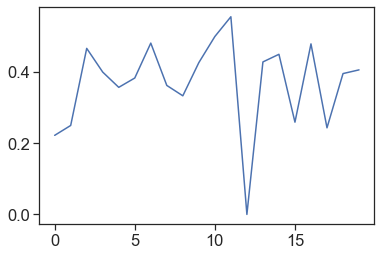

In [1703]:
plt.plot(mus)

In [1704]:
np.mean([np.mean(i) for i in res_dict.values()])

0.39504714582375

In [1705]:
np.mean([np.mean(i) for i in res_dict.values()])

0.39504714582375

In [1706]:
[len(i) for i in res_dict.values()]

[29, 37, 40, 36, 41, 37, 45, 41, 26, 34]

In [1707]:
['p={:.3f}   | fc={:.2f}'.format(stt.binom_test(np.sum(i),len(i),p=1/9.,alternative='greater'),np.mean(i)) for i in res_dict.values()]

['p=0.000   | fc=0.48',
 'p=0.000   | fc=0.78',
 'p=0.000   | fc=0.47',
 'p=0.000   | fc=0.36',
 'p=0.682   | fc=0.10',
 'p=0.000   | fc=0.41',
 'p=0.057   | fc=0.20',
 'p=0.033   | fc=0.22',
 'p=0.006   | fc=0.31',
 'p=0.000   | fc=0.62']

<ipython-input-1573-64cf0191b5f0>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


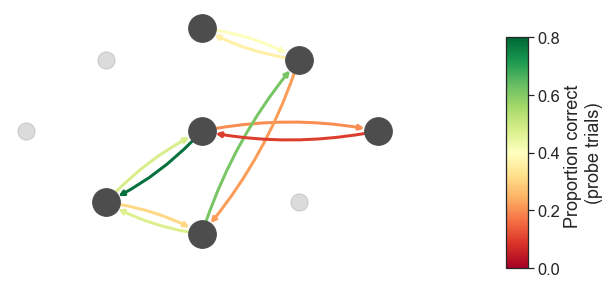

In [1708]:
make_plot(res_dict,mx=.8)

<ipython-input-1573-64cf0191b5f0>:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


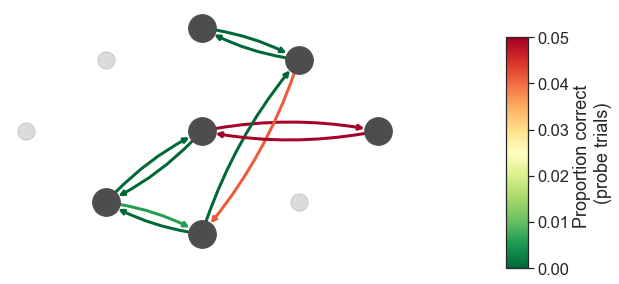

In [1709]:
make_plot(res_dict,mx=.05,color='pval')

In [1454]:
state_dict = eval(lines[5][2:-1])
event_dict = eval(lines[7][2:-1])
event_dict2 = {v: k for k, v in event_dict.items()}

seq = [1,3,6,7,2,0,2,7,6,3]

In [9]:
session_variables = eval(re.findall(r'(\{.*\})',lines[-1])[0])
probe_dur = float(session_variables['probe_dur'])

In [860]:
session_variables = eval(lines[-1][9:])
probe_dur = float(session_variables['probe_dur'])
probes = [float(re.findall('D ([0-9]*)',i)[0]) for i in lines if '33\n' in i and 'D' in i]

In [862]:
fracL = float([re.findall(r'fracL:(.*)\n',l_)[0] for l_ in lines if re.findall(r'fracL:(.*)\n',l_)][-1])
print('fracL:{:.2f}%'.format(100*fracL))

fracL:80.30%


In [863]:
def get_inpoke_data(lines):
    
    event_line = [ix for ix,l in enumerate(lines) if l[0]=='E'][0]
    state_line = [ix for ix,l in enumerate(lines) if l[0]=='E'][0]

    event_dict = eval(event_line[2:-1])
    state_dict = eval(state_line[2:-1])
    inPoke_evs = sorted([(k,v) for k,v in event_dict.items() if (re.findall(r'poke_[0-9]',k) and 'out' not in k)])
    inPoke_ids = [i[1] for i in inPoke_evs]
    
    
    inPokes = []
    inPoke_ts = []
    for l_ in lines:
        d_ = re.findall('D [0-9]* ([0-9]*)\n',l_)

        if d_:
            if int(d_[0]) in inPoke_ids:

                t = re.findall('D ([0-9]*) [0-9]*\n',l_)[0]
                inPoke_ts.append(float(t))
                #pkd = re.findall(d)
                inPokes.append(int(event_dict2[int(d_[0])][-1]))
    return np.array(inPokes), np.array(inPoke_ts)

In [864]:
inPokes, inPoke_ts = get_inpoke_data(lines)

In [875]:
def get_tar_pokes(lines):
    next_pokes_targets = [int(l_[-2]) for l_ in lines if (l_[0]=='P' and 'nREWS' not in l_)]
    next_poke_target_ts = [float(re.findall(r'P ([0-9]*)',l_)[0]) for l_ in lines if (l_[0]=='P' and 'nREWS' not in l_)]
    return next_pokes_targets, next_poke_target_ts

In [867]:

def get_inpoke_data(lines):
    
    event_line = [ix for ix,l in enumerate(lines) if l[0]=='E'][0]
    state_line = [ix for ix,l in enumerate(lines) if l[0]=='E'][0]

    event_dict = eval(event_line[2:-1])
    state_dict = eval(state_line[2:-1])
    inPoke_evs = sorted([(k,v) for k,v in event_dict.items() if (re.findall(r'poke_[0-9]',k) and 'out' not in k)])
    inPoke_ids = [i[1] for i in inPoke_evs]
    
    
    inPokes = []
    inPoke_ts = []
    for l_ in lines:
        d_ = re.findall('D [0-9]* ([0-9]*)\n',l_)

        if d_:
            if int(d_[0]) in inPoke_ids:

                t = re.findall('D ([0-9]*) [0-9]*\n',l_)[0]
                inPoke_ts.append(float(t))
                #pkd = re.findall(d)
                inPokes.append(int(event_dict2[int(d_[0])][-1]))
    return np.array(inPokes), np.array(inPoke_ts)


def get_target_at_t(T,next_pokes_targets,next_poke_target_ts):
    """ Function returns which poke is the target at a given point in time """
    if type(next_poke_target_ts)!=np.array:
        next_poke_target_ts = np.array(next_poke_target_ts)
        
    ix = np.min(np.where(next_poke_target_ts>T)[0])
    target = next_pokes_targets[ix]
    if ix==0:
        prev_target = 99
    else:
        prev_target = next_pokes_targets[ix-1]

    return target, prev_target

def get_tar_pokes(lines):
    next_pokes_targets = [int(l_[-2]) for l_ in lines if (l_[0]=='P' and 'nREWS' not in l_)]
    next_poke_target_ts = [float(re.findall(r'P ([0-9]*)',l_)[0]) for l_ in lines if (l_[0]=='P' and 'nREWS' not in l_)]
    return next_pokes_targets, next_poke_target_ts
    
    
def evaluate_probe_trials(lines,res_dict=None):
    
    next_pokes_targets, next_poke_target_ts = get_tar_pokes(lines)
    session_variables = eval(re.findall(r'(\{.*\})',lines[-1])[0])
    probe_dur = float(session_variables['probe_dur'])
    inPokes, inPoke_ts = get_inpoke_data(lines)
    if res_dict is None:
        res_dict = {}

    probe_starts = np.array(probes)-probe_dur
    for pt_ in probe_starts[:-1]:
        target,prev_target = get_target_at_t(pt_,next_pokes_targets,next_poke_target_ts)
        k_ = str(target) + str(prev_target)

        ix_ = np.min(np.where(np.array(inPoke_ts)>(pt_+50))[0])
        get_nextPoke = True
        while get_nextPoke:
            nextPoke = inPokes[ix_]-1
            if nextPoke!=prev_target:
                get_nextPoke = False
            ix_ += 1


        correct = nextPoke==target
        if k_ not in res_dict.keys():
            res_dict[k_] = [correct]
        else:
            res_dict[k_].append(correct)

    return res_dict

In [885]:
evaluate_probe_trials(lines)

{'27': [False, True, False],
 '67': [False, False],
 '76': [True],
 '72': [False, False],
 '31': [False, True],
 '63': [True, True],
 '36': [True],
 '13': [False]}

In [884]:
def evaluate_probe_trials(lines,res_dict=None):
    
    next_pokes_targets, next_poke_target_ts = get_tar_pokes(lines)
    session_variables = eval(re.findall(r'(\{.*\})',lines[-1])[0])
    probe_dur = float(session_variables['probe_dur'])
    inPokes, inPoke_ts = get_inpoke_data(lines)
    if res_dict is None:
        res_dict = {}

    probe_starts = np.array(probes)-probe_dur
    for pt_ in probe_starts[:-1]:
        target,prev_target = get_target_at_t(pt_,next_pokes_targets,next_poke_target_ts)
        k_ = str(target) + str(prev_target)

        ix_ = np.min(np.where(np.array(inPoke_ts)>(pt_+50))[0])
        get_nextPoke = True
        while get_nextPoke:
            nextPoke = inPokes[ix_]-1
            if nextPoke!=prev_target:
                get_nextPoke = False
            ix_ += 1


        correct = nextPoke==target
        if k_ not in res_dict.keys():
            res_dict[k_] = [correct]
        else:
            res_dict[k_].append(correct)

    return res_dict

In [868]:
#def evaluate_probe_trials(probes,probe_dur,next_pokes_targets,next_poke_target_ts,inPoke_ts,inPokes):

probe_starts = np.array(probes)-probe_dur

res_dict = {}
for pt_ in probe_starts[:-1]:
    target,prev_target = get_target_at_t(pt_,next_pokes_targets,next_poke_target_ts)
    #prev_target = get_target_at_t(pt_-100,next_pokes_targets,next_poke_target_ts)
    #print(target,prev_target)
    k_ = str(target) + str(prev_target)

    ix_ = np.min(np.where(np.array(inPoke_ts)>(pt_+50))[0])
    get_nextPoke = True
    while get_nextPoke:
        #print(ix_,ix_)
        nextPoke = inPokes[ix_]-1
        if nextPoke!=prev_target:
            get_nextPoke = False
        ix_ += 1

    #print(target,nextPoke)
    correct = nextPoke==target
    #correct = target in inPokes[ix-1:ix+5]
    if k_ not in res_dict.keys():
        res_dict[k_] = [correct]
    else:
        res_dict[k_].append(correct)
#    return res_dict

In [85]:
[(np.mean(i),k) for k,i in res_dict.items()]

[(0.2222222222222222, '31'),
 (0.2222222222222222, '76'),
 (0.23076923076923078, '72'),
 (0.07692307692307693, '27'),
 (0.75, '20'),
 (0.2857142857142857, '13'),
 (0.125, '36'),
 (0.3, '63'),
 (0.0, '67'),
 (0.0, '02')]

In [808]:
row['entry_time'][0]

'2021-03-25-062714'

In [847]:
file_loc = "C:/Users/takam/Desktop/pyhomecage/mice/468631_4.csv"
csv1 = pd.read_csv(file_loc,index_col=0)

In [848]:
for ix, row in csv1.iterrows():
    if row['entry_time'][0]!='2':
        csv1.loc[ix,'entry_time'] = csv1.loc[ix,'entry_time'][1:]
    if row['exit_time'][0]!='2':
        csv1.loc[ix,'exit_time'] = csv1.loc[ix,'exit_time'][1:]

In [845]:
#csv1.to_csv(file_loc)

In [791]:
dates = []
for i in csv1['entry_time'].values:
    if i[0]==2:
        dates.append(i[6:])
    else:
        dates.append(i[1:][6:])

In [792]:
weights = []
for i in csv1['weight'].values:
    weights.append(i)

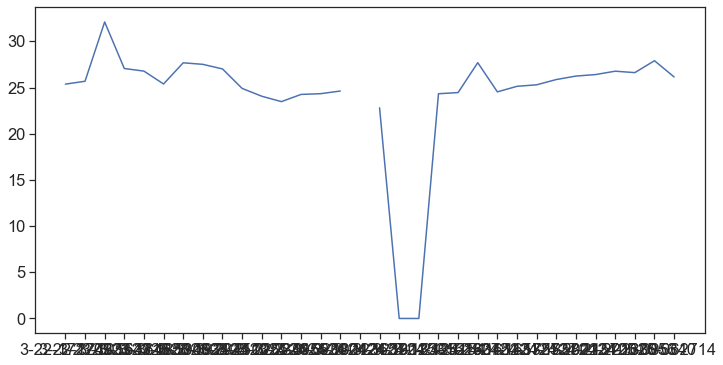

In [941]:
weights = [-.1,-.01,.1]

In [942]:
filt_w = [0] + [1./(abs(weights[ix]-j)+abs(weights[ix+2]-j))**2 for ix,j in enumerate(weights[1:-1])] + [0]
filt_sum = float(sum(filt_w))
filt_w2 = [wtmp/filt_sum for wtmp in filt_w]
weight = sum([i*j for i,j in zip(weights,filt_w2)])


In [943]:
filt_w

[0, 24.999999999999996, 0]